In [1]:
# Import libraries
import numpy as np
import gzip
import struct
import matplotlib.pyplot as plt

In [ ]:
# Read raw data
def load_images(filename):
    with gzip.open(filename,'rb') as f:
        magic, num, rows, cols = struct.unpack('>IIII',f.read(16)) # type: ignore
        data = np.frombuffer(f.read(),dtype=np.uint8)
        images = data.reshape(num,rows, cols)
    return images

def load_labels(filename):
    with gzip.open(filename,'rb')as f:
        magic, num = struct.unpack(">II",f.read(8))
        labels = np.frombuffer(f.read(),dtype=np.uint8)
        return labels

train_images = load_images('./data/MNIST/raw/train-images-idx3-ubyte.gz')
train_labels = load_labels('./data/MNIST/raw/train-labels-idx1-ubyte.gz')

In [3]:
# Data preprocessing
train_images = train_images.astype(np.float32)/255.0

train_images = train_images.reshape(train_images.shape[0],-1)

def one_hot(labels, num_classes = 10):
    result = np.zeros((labels.size, num_classes))
    result[np.arange(labels.size),labels] = 1
    return result

train_labels_oh = one_hot(train_labels)

In [4]:
# Neural Network Initialization
input_size = 784
hidden_size = 128
output_size = 10

np.random.seed(0)
W1 = np.random.randn(input_size, hidden_size) * 0.01
b1 = np.zeros((1, hidden_size))
W2 = np.random.randn(hidden_size, output_size) * 0.01
b2 = np.zeros((1, output_size))


# Actication Functions
def relu(x):
    return np.maximum(0, x)


def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)


# Forward propagation
def forward(x):
    z1 = np.dot(x, W1) + b1
    a1 = relu(z1)
    z2 = np.dot(a1, W2) + b2
    a2 = softmax(z2)
    return z1, a1, z2, a2


#Loss function
def cross_entropy_loss(y_true, y_pred):
    eps = 1e-12
    y_pred = np.clip(y_pred, eps, 1. - eps)
    N = y_true.shape[0]
    return -np.sum(y_true * np.log(y_pred)) / N


# Backward Propagation
def backward(x, y_true, z1, a1, z2, a2, lr=0.01):
    global W1, b1, W2, b2
    m = x.shape[0]

    # Output layer gradients
    dz2 = (a2 - y_true) / m
    dW2 = np.dot(a1.T, dz2)
    db2 = np.sum(dz2, axis=0, keepdims=True)

    # Hidden layer gradients
    da1 = np.dot(dz2, W2.T)
    dz1 = da1 * (z1 > 0)
    dW1 = np.dot(x.T, dz1)
    db1 = np.sum(dz1, axis=0, keepdims=True)

    # Gradient descent parameter update
    W2 -= lr * dW2
    b2 -= lr * db2
    W1 -= lr * dW1
    b1 -= lr * db1

In [5]:
# Training loop
epochs = 60
batch_size = 256
loss_history = []

for epoch in range(epochs):
    permutation = np.random.permutation(train_images.shape[0])
    X_shuffled = train_images[permutation]
    Y_shuffled = train_labels_oh[permutation]

    epoch_loss = 0
    batches = 0

    for i in range(0, X_shuffled.shape[0], batch_size):
        x_batch = X_shuffled[i:i + batch_size]
        y_batch = Y_shuffled[i:i + batch_size]

        z1, a1, z2, a2 = forward(x_batch)
        loss = cross_entropy_loss(y_batch, a2)
        backward(x_batch, y_batch, z1, a1, z2, a2)

        epoch_loss += loss
        batches += 1

    avg_loss = epoch_loss / batches
    loss_history.append(avg_loss)
    print(f"Epoch {epoch + 1:02d} | Loss: {avg_loss:.4f}")

Epoch 01 | Loss: 2.2833
Epoch 02 | Loss: 2.1511
Epoch 03 | Loss: 1.7253
Epoch 04 | Loss: 1.2126
Epoch 05 | Loss: 0.9006
Epoch 06 | Loss: 0.7281
Epoch 07 | Loss: 0.6240
Epoch 08 | Loss: 0.5563
Epoch 09 | Loss: 0.5088
Epoch 10 | Loss: 0.4733
Epoch 11 | Loss: 0.4471
Epoch 12 | Loss: 0.4257
Epoch 13 | Loss: 0.4091
Epoch 14 | Loss: 0.3954
Epoch 15 | Loss: 0.3838
Epoch 16 | Loss: 0.3737
Epoch 17 | Loss: 0.3653
Epoch 18 | Loss: 0.3581
Epoch 19 | Loss: 0.3513
Epoch 20 | Loss: 0.3459
Epoch 21 | Loss: 0.3402
Epoch 22 | Loss: 0.3351
Epoch 23 | Loss: 0.3306
Epoch 24 | Loss: 0.3265
Epoch 25 | Loss: 0.3226
Epoch 26 | Loss: 0.3187
Epoch 27 | Loss: 0.3155
Epoch 28 | Loss: 0.3120
Epoch 29 | Loss: 0.3087
Epoch 30 | Loss: 0.3055
Epoch 31 | Loss: 0.3028
Epoch 32 | Loss: 0.2997
Epoch 33 | Loss: 0.2974
Epoch 34 | Loss: 0.2942
Epoch 35 | Loss: 0.2919
Epoch 36 | Loss: 0.2892
Epoch 37 | Loss: 0.2873
Epoch 38 | Loss: 0.2843
Epoch 39 | Loss: 0.2818
Epoch 40 | Loss: 0.2796
Epoch 41 | Loss: 0.2770
Epoch 42 | Loss:

Training Accuracy: 0.9368


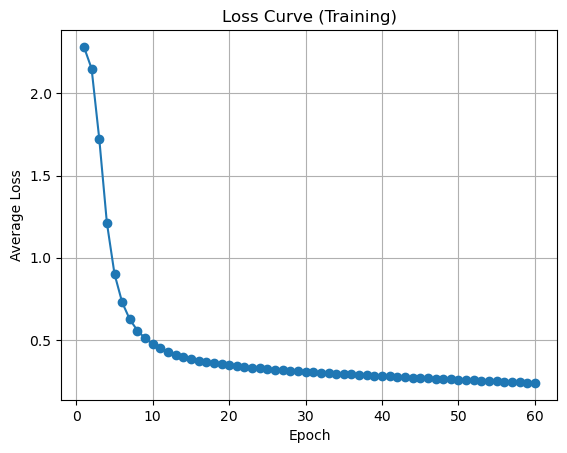

In [6]:
# Evaluation
def accuracy(x, y_true):
    _, _, _, a2 = forward(x)
    y_pred = np.argmax(a2, axis=1)
    y_true_labels = np.argmax(y_true, axis=1)
    return np.mean(y_pred == y_true_labels)


print("Training Accuracy:", accuracy(train_images[:10000], train_labels_oh[:10000]))

# Plot training loss curve
plt.plot(range(1, epochs + 1), loss_history, marker='o')
plt.title('Loss Curve (Training)')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.grid(True)
plt.show()



In [ ]:
# Test Phase
test_images = load_images('./data/MNIST/raw/t10k-images-idx3-ubyte.gz')
test_labels = load_labels('./data/MNIST/raw/t10k-labels-idx1-ubyte.gz')

test_images = test_images.astype(np.float32) / 255.0
test_images = test_images.reshape(test_images.shape[0], -1)
test_labels_oh = one_hot(test_labels)

test_acc = accuracy(test_images, test_labels_oh)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

Test Accuracy: 93.37%
